In [117]:
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np

from pathlib import Path
from pprint import pprint

from collections import Counter
from collections import defaultdict

In [213]:
def get_run_files(root="/orange/ufdatastudios/alexwebber/mixteclabeling/out/runs"):
    return [x for x in Path(root).glob("**/*.0") if x.suffix == ".0"]

def get_scalar_run_tensorboard(tag, filepath:str):
    values,steps = [],[]
    for e in tf.compat.v1.train.summary_iterator(filepath):
        if len(e.summary.value)>0: #Skip first empty element
            if e.summary.value[0].tag==tag:
                tensor = e.summary.value[0]
                value,step = (e.summary.value[0].simple_value, e.step)
                values.append(value)
                steps.append(step)
    return values,steps

def return_the_substring(text, keylist):
    for key in keylist:
        if key in text:
            return key
    return None

def round_it(listofvalues, by=5):
    """Rounds each value in the list of values to the closest by."""
    return map(lambda x: x-x%by, listofvalues)

list_of_tags = ["train_f1_epoch", "val_f1_epoch"]
# list_of_tags = ["train_f1_epoch"]

In [224]:
def generate_plot():
    files = get_run_files()
    tags = list_of_tags
    
    # Grab tags from the tensorboard log files
    for tag in tags:
        lr = {"0.0001": { "steps": [], "values": [] },
              "0.001": { "steps": [], "values": [] },
              "0.01": { "steps": [], "values": [] } }
        
        for file in map(str,files):
            values, steps = get_scalar_run_tensorboard(tag, file)
            steps = round_it(steps, 50)
            
            lr.get(return_the_substring(file, lr.keys()))["steps"].extend(steps)
            lr.get(return_the_substring(file, lr.keys()))["values"].extend(values)
    
        # Get mean and stddev for each step in lr2
        lr2 = {}
        for i, (k,data) in enumerate(lr.items()):
            d = defaultdict(list)
            for (step, value) in zip(data["steps"], data["values"]):
                d[step].append(value)
            # Get avg and stddev of each step
            d2 = {}
            for (step, vals) in d.items():
                d2[step] = {"avg": np.average(vals), "std": np.std(vals) }
            lr2[k] = d2
            
        plt.figure()

        for key, data in lr2.items():
            # e.g. key = "0.01", data = {step: { avg, std } }

            datakeys = list(data.keys())
            averages = list(map(lambda x: x["avg"], list(data.values())))
            upperbound = list(map(lambda x: x["avg"] + x["std"], list(data.values())))
            lowerbound = list(map(lambda x: x["avg"] - x["std"], list(data.values())))

            plt.plot(datakeys, averages, linewidth=1, label=key)
            plt.fill_between(datakeys, upperbound, lowerbound, alpha=.5, linewidth=0)   

        plt.legend(lr.keys(), loc="lower right")
        plt.xlabel("steps")
        plt.ylabel(tag)

        #print(f'{sorted(Counter(lr["0.01"]["steps"]).items())}')


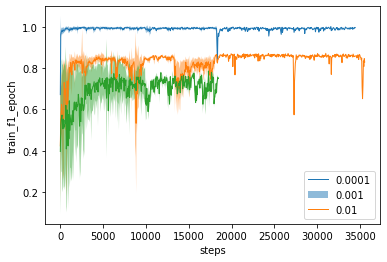

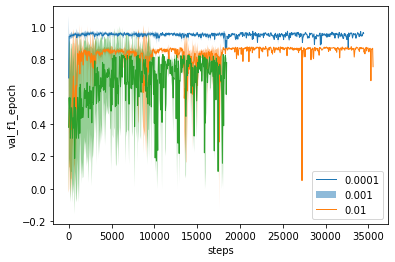

In [225]:
generate_plot()

In [226]:
get_run_files()

[PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/runs/2023-08-15--lr0.01--bs128--transformsHFlipVFlipRotateErase/version_0/events.out.tfevents.1692150776.c1106a-s11.ufhpc.30381.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/runs/2023-08-15--lr0.0001--bs16--transformsHFlipVFlipRotateErase/version_0/events.out.tfevents.1692150775.c0803a-s29.ufhpc.106737.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/runs/2023-08-15--lr0.001--bs16--transformsHFlipVFlipRotateErase/version_0/events.out.tfevents.1692150773.c1106a-s11.ufhpc.30382.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/runs/2023-08-15--lr0.001--bs128--transformsHFlipVFlipRotateErase/version_0/events.out.tfevents.1692150772.c0804a-s11.ufhpc.107985.0'),
 PosixPath('/orange/ufdatastudios/alexwebber/mixteclabeling/runs/2023-08-15--lr0.0001--bs32--transformsHFlipVFlipRotateErase/version_0/events.out.tfevents.1692150778.c0801a-s11.ufhpc.1081.0'),
 PosixPath('/orange/ufdatastudi